In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import numpy as np
import pandas as pd 
from keras import initializers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
import seaborn as sns
from keras.models import load_model

Using TensorFlow backend.


Total Data:  89119
Positif:  32375
Kasar:  36196
Dewasa:  20548


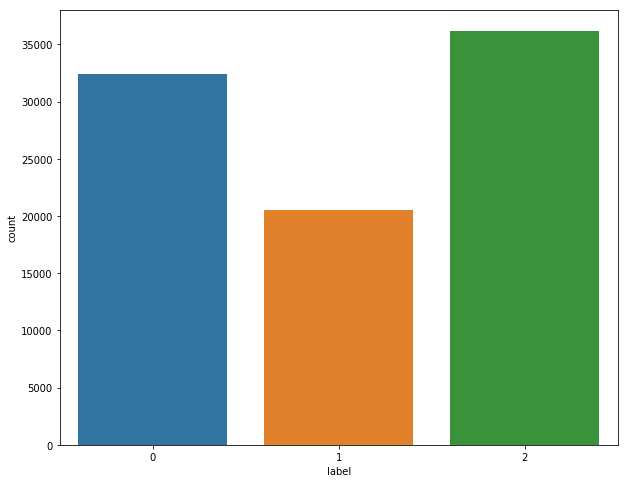

In [0]:
data = pd.read_excel("/content/drive/Shared drives/Newbie Maning/Data Baru/all-data-clean.xlsx")
data.replace('', np.nan, inplace=True)
data.dropna(inplace=True) # memastikan tidak ada nilai yang kosong
dewasa = data.loc[data['label'] == 1, 'text'].copy().reset_index(drop=True)
positif = data.loc[data['label'] == 0, 'text'].copy().reset_index(drop=True)
kasar = data.loc[data['label'] == 2, 'text'].copy().reset_index(drop=True)
print("Total Data: ", len(data))
print("Positif: ", len(positif))
print("Kasar: ", len(kasar))
print("Dewasa: ", len(dewasa))

plt.figure(figsize=(10,8))
sns.countplot(x='label', data=data)
plt.show()

In [0]:
# Splitting Data
text = data['text'].values
label = data['label'].values
data_train, data_test, label_train, label_test = train_test_split(text, label, test_size=0.5, random_state=42)
data_test, data_val, label_test, label_val = train_test_split(data_test, label_test, test_size= 0.5, random_state=42)

In [0]:
# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)

vocab = max([len(tokenizer.word_index)]) + 1 # kamus kata 
maxlen = max([len(i.split()) for i in text]) # panjang input sequence
batch_size = 256 #penentuan jumlah sample yang ditraining pada tiap epoch
num_epochs = 10 # banyak iterasi pada saat training model 
initializer = initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=2)

In [0]:
#Data Train
X_train = tokenizer.texts_to_sequences(data_train)
X_train = pad_sequences(X_train, maxlen=maxlen)
Y_train = to_categorical(label_train, num_classes = 3)

#Data Test
X_test = tokenizer.texts_to_sequences(data_test)
X_test = pad_sequences(X_test, maxlen=maxlen)
Y_test = to_categorical(label_test, num_classes = 3)

#Data Validation
X_val = tokenizer.texts_to_sequences(data_val)
X_val = pad_sequences(X_val, maxlen=maxlen)
Y_val = to_categorical(label_val, num_classes = 3)

In [0]:
def plot_history(histories, key='loss'):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

        plt.xlabel('Epochs')
        plt.ylabel(key.replace('_',' ').title())
        plt.legend()
        plt.xlim([0,max(history.epoch)])
        
def evaluation(model, X, Y):
    # Predict the values
    Y_pred = model.predict(X)
    Y_pred_class = np.argmax(Y_pred, axis=1)
    Y_act = Y
    # accuracy
    accuracy = accuracy_score(Y_act, Y_pred_class, normalize=True)
    print("Accuracy: %.2f" % (accuracy*100), "%")
    # precision
    precision = precision_score(Y_act, Y_pred_class, average='weighted')
    print("Precision: %.2f" % (precision*100), "%")
    # recall
    recall = recall_score(Y_act, Y_pred_class, average='macro')
    print("Recall: %.2f" % (recall*100), "%")
    
    return Y_act, Y_pred_class

def conf_matrix(Y_act, Y_pred):
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_act, Y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_mtx, annot=True, fmt="d");
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [0]:
def get_model1(X, Y):
    model = Sequential() 
    model.add(Embedding(input_dim = vocab, output_dim = 128, input_length = maxlen, embeddings_initializer = initializer))
    model.add(LSTM(128, recurrent_initializer = initializer, kernel_initializer = initializer))
    model.add(Dense(3, activation='softmax', kernel_initializer = initializer)) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model

In [0]:
model1 = get_model1(X_train, Y_train)






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 58, 128)           10828288  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 10,960,259
Trainable params: 10,960,259
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# training model
history1 = model1.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_data=(X_val, Y_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 44559 samples, validate on 22280 samples
Epoch 1/10
44559/44559 [==============================] - 31s 699us/step - loss: 0.5981 - acc: 0.7246 - val_loss: 0.3118 - val_acc: 0.8757
Epoch 2/10
44559/44559 [==============================] - 26s 586us/step - loss: 0.1652 - acc: 0.9440 - val_loss: 0.2737 - val_acc: 0.9053
Epoch 3/10
44559/44559 [==============================] - 26s 587us/step - loss: 0.0927 - acc: 0.9715 - val_loss: 0.3086 - val_acc: 0.8947
Epoch 4/10
44559/44559 [==============================] - 26s 582us/step - loss: 0.0468 - acc: 0.9860 - val_loss: 0.3072 - val_acc: 0.9016
Epoch 5/10
44559/44559 [==============================] - 26s 587us/step - loss: 0.0315 - acc: 0.9909 - val_loss: 0.3652 - val_acc: 0.8994
Epoch 6/10
44559/44559 [==============================] - 26s 587us/step - loss: 0.0221 - acc: 0.9939 - val_loss: 0.4285 - val_acc: 0.8921
Epoch 7/10
44559/4455

In [0]:
print("Evaluasi Data Test")
Y_act, Y_pred = evaluation(model1, X_test, label_test)
print("Evaluasi Data Train")
Y_act, Y_pred = evaluation(model1, X_train, label_train)
print("Evaluasi Data Validation")
Y_act, Y_pred = evaluation(model1, X_val, label_val)

Evaluasi Data Test
Accuracy: 89.16 %
Precision: 89.16 %
Recall: 89.81 %
Evaluasi Data Train
Accuracy: 99.74 %
Precision: 99.74 %
Recall: 99.74 %
Evaluasi Data Validation
Accuracy: 89.69 %
Precision: 89.69 %
Recall: 90.42 %


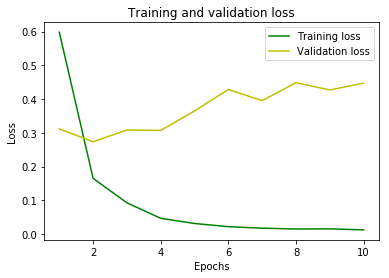

In [0]:
plt.clf()
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
def get_model2(X, Y):
    model = Sequential()
    model.add(Embedding(input_dim = vocab, output_dim = 128, input_length = maxlen, embeddings_initializer = initializer))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, recurrent_initializer = initializer, kernel_initializer = initializer))
    model.add(Dense(3, activation='softmax', kernel_initializer = initializer)) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model

In [0]:
model2 = get_model2(X_train, Y_train)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 58, 128)           10828288  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 58, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 10,960,259
Trainable params: 10,960,259
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# training model
history2 = model2.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_data=(X_val, Y_val))

Train on 44559 samples, validate on 22280 samples
Epoch 1/10
44559/44559 [==============================] - 32s 725us/step - loss: 0.6507 - acc: 0.6932 - val_loss: 0.3153 - val_acc: 0.8776
Epoch 2/10
44559/44559 [==============================] - 31s 698us/step - loss: 0.2228 - acc: 0.9211 - val_loss: 0.2505 - val_acc: 0.9057
Epoch 3/10
44559/44559 [==============================] - 31s 696us/step - loss: 0.1136 - acc: 0.9627 - val_loss: 0.2550 - val_acc: 0.9094
Epoch 4/10
44559/44559 [==============================] - 31s 700us/step - loss: 0.0688 - acc: 0.9773 - val_loss: 0.3038 - val_acc: 0.9043
Epoch 5/10
44559/44559 [==============================] - 31s 692us/step - loss: 0.0464 - acc: 0.9853 - val_loss: 0.3188 - val_acc: 0.9066
Epoch 6/10
44559/44559 [==============================] - 31s 695us/step - loss: 0.0354 - acc: 0.9883 - val_loss: 0.3403 - val_acc: 0.8998
Epoch 7/10
44559/44559 [==============================] - 31s 691us/step - loss: 0.0302 - acc: 0.9900 - val_loss: 0.

In [0]:
print("Evaluasi Data Test")
Y_act, Y_pred = evaluation(model2, X_test, label_test)
print("Evaluasi Data Train")
Y_act, Y_pred = evaluation(model2, X_train, label_train)
print("Evaluasi Data Validation")
Y_act, Y_pred = evaluation(model2, X_val, label_val)

Evaluasi Data Test
Accuracy: 89.62 %
Precision: 89.59 %
Recall: 90.44 %
Evaluasi Data Train
Accuracy: 99.76 %
Precision: 99.76 %
Recall: 99.77 %
Evaluasi Data Validation
Accuracy: 90.09 %
Precision: 90.06 %
Recall: 90.95 %


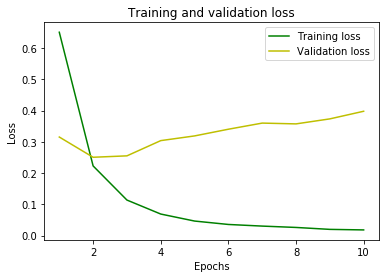

In [0]:
plt.clf()
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
def get_model3(X, Y):
    model = Sequential()
    model.add(Embedding(input_dim = vocab, output_dim = 64, input_length = maxlen, embeddings_initializer = initializer))
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, recurrent_initializer = initializer, kernel_initializer = initializer))
    model.add(Dense(3, activation='softmax', kernel_initializer = initializer)) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model

In [0]:
model3 = get_model3(X_train, Y_train)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 58, 64)            5414144   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 58, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 5,447,363
Trainable params: 5,447,363
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history3 = model3.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_data=(X_val, Y_val))

Train on 44559 samples, validate on 22280 samples
Epoch 1/10
44559/44559 [==============================] - 32s 714us/step - loss: 0.7511 - acc: 0.6329 - val_loss: 0.4217 - val_acc: 0.8370
Epoch 2/10
44559/44559 [==============================] - 30s 675us/step - loss: 0.2933 - acc: 0.8920 - val_loss: 0.2843 - val_acc: 0.8959
Epoch 3/10
44559/44559 [==============================] - 31s 689us/step - loss: 0.1667 - acc: 0.9446 - val_loss: 0.2882 - val_acc: 0.9014
Epoch 4/10
44559/44559 [==============================] - 30s 683us/step - loss: 0.1076 - acc: 0.9648 - val_loss: 0.2850 - val_acc: 0.9038
Epoch 5/10
44559/44559 [==============================] - 31s 686us/step - loss: 0.0723 - acc: 0.9775 - val_loss: 0.3116 - val_acc: 0.9029
Epoch 6/10
44559/44559 [==============================] - 30s 682us/step - loss: 0.0547 - acc: 0.9825 - val_loss: 0.3223 - val_acc: 0.9029
Epoch 7/10
44559/44559 [==============================] - 31s 690us/step - loss: 0.0439 - acc: 0.9861 - val_loss: 0.

In [0]:
print("Evaluasi Data Test")
Y_act, Y_pred = evaluation(model3, X_test, label_test)
print("Evaluasi Data Train")
Y_act, Y_pred = evaluation(model3, X_train, label_train)
print("Evaluasi Data Validation")
Y_act, Y_pred = evaluation(model3, X_val, label_val)


Evaluasi Data Test
Accuracy: 89.17 %
Precision: 89.24 %
Recall: 90.20 %
Evaluasi Data Train
Accuracy: 99.66 %
Precision: 99.66 %
Recall: 99.69 %
Evaluasi Data Validation
Accuracy: 89.65 %
Precision: 89.68 %
Recall: 90.70 %


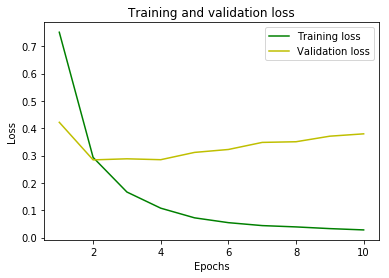

In [0]:
plt.clf()
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
def get_model4(X, Y):
    model = Sequential() 
    model.add(Embedding(input_dim = vocab, output_dim = 64, input_length = maxlen, embeddings_initializer = initializer))
    model.add(LSTM(64, recurrent_initializer = initializer, kernel_initializer = initializer))
    model.add(Dense(3, activation='sigmoid', kernel_initializer = initializer)) 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model

In [0]:
model4 = get_model4(X_train, Y_train)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 58, 64)            5414144   
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 195       
Total params: 5,447,363
Trainable params: 5,447,363
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history4 = model4.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_data=(X_val, Y_val))

Train on 44559 samples, validate on 22280 samples
Epoch 1/10
44559/44559 [==============================] - 27s 605us/step - loss: 0.5365 - acc: 0.7221 - val_loss: 0.3433 - val_acc: 0.8577
Epoch 2/10
44559/44559 [==============================] - 26s 576us/step - loss: 0.2058 - acc: 0.9264 - val_loss: 0.2582 - val_acc: 0.8913
Epoch 3/10
44559/44559 [==============================] - 25s 569us/step - loss: 0.1088 - acc: 0.9664 - val_loss: 0.1921 - val_acc: 0.9304
Epoch 4/10
44559/44559 [==============================] - 25s 569us/step - loss: 0.0599 - acc: 0.9826 - val_loss: 0.2022 - val_acc: 0.9308
Epoch 5/10
44559/44559 [==============================] - 25s 566us/step - loss: 0.0386 - acc: 0.9889 - val_loss: 0.2239 - val_acc: 0.9274
Epoch 6/10
44559/44559 [==============================] - 25s 570us/step - loss: 0.0283 - acc: 0.9920 - val_loss: 0.2436 - val_acc: 0.9284
Epoch 7/10
44559/44559 [==============================] - 25s 563us/step - loss: 0.0201 - acc: 0.9948 - val_loss: 0.

In [0]:
print("Evaluasi Data Test")
Y_act, Y_pred = evaluation(model4, X_test, label_test)
print("Evaluasi Data Train")
Y_act, Y_pred = evaluation(model4, X_train, label_train)
print("Evaluasi Data Validation")
Y_act, Y_pred = evaluation(model4, X_val, label_val)

Evaluasi Data Test
Accuracy: 88.75 %
Precision: 88.82 %
Recall: 89.61 %
Evaluasi Data Train
Accuracy: 99.69 %
Precision: 99.69 %
Recall: 99.70 %
Evaluasi Data Validation
Accuracy: 89.02 %
Precision: 89.07 %
Recall: 89.98 %


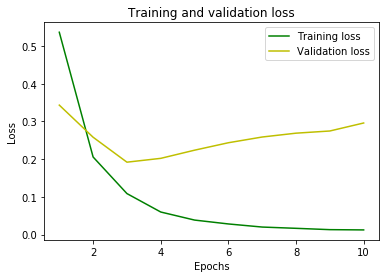

In [0]:
plt.clf()
loss = history4.history['loss']
val_loss = history4.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
def get_model5(X, Y):
  model_lstm = Sequential()
  model_lstm.add(Embedding(input_dim = vocab, output_dim = 64, input_length = maxlen))
  model_lstm.add(LSTM(64, dropout = 0.4, recurrent_dropout = 0.4))
  model_lstm.add(Dropout(0.4))
  model_lstm.add(Dense(3, activation = 'softmax'))
  model_lstm.compile(
      loss='categorical_crossentropy',
      optimizer='Adam',
      metrics=['accuracy']
  )
  print(model_lstm.summary())
    
  return model_lstm

In [0]:
model5 = get_model5(X_train, Y_train)
history5 = model5.fit(X_train, Y_train, batch_size=batch_size, epochs=5, verbose=1, validation_data=(X_val, Y_val))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 58, 64)            5414144   
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 195       
Total params: 5,447,363
Trainable params: 5,447,363
Non-trainable params: 0
_________________________________________________________________
None
Train on 44559 samples, validate on 22280 samples
Epoch 1/5
44559/44559 [==============================] - 32s 723us/step - loss: 0.6721 - acc: 0.6999 - val_loss: 0.3391 - val_acc: 0.8661
Epoch 2/5
44559/44559 [==========================

In [0]:
print("Evaluasi Data Test")
Y_act, Y_pred = evaluation(model5, X_test, label_test)
print("Evaluasi Data Train")
Y_act, Y_pred = evaluation(model5, X_train, label_train)
print("Evaluasi Data Validation")
Y_act, Y_pred = evaluation(model5, X_val, label_val)


Evaluasi Data Test
Accuracy: 90.30 %
Precision: 90.29 %
Recall: 91.10 %
Evaluasi Data Train
Accuracy: 99.42 %
Precision: 99.42 %
Recall: 99.46 %
Evaluasi Data Validation
Accuracy: 90.43 %
Precision: 90.41 %
Recall: 91.22 %


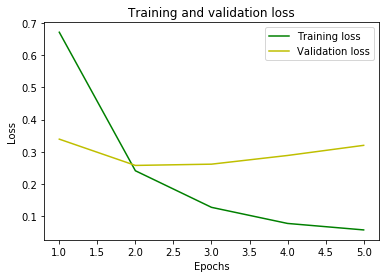

In [0]:
plt.clf()
loss = history5.history['loss']
val_loss = history5.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
embed_dim = 128
lstm_out = 200
batch_size = 32

def get_model6(X, Y):
  model = Sequential()
  model.add(Embedding(2500, embed_dim,input_length = X.shape[1], dropout = 0.2))
  model.add(LSTM(lstm_out, dropout_U = 0.2, dropout_W = 0.2))
  model.add(Dense(3,activation='softmax'))
  model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
  print(model.summary())
  
  return model

In [0]:
model6 = get_model6(X_train, Y_train)
history6 = model6.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_data=(X_val, Y_val))

In [0]:
print("Evaluasi Data Test")
Y_act, Y_pred = evaluation(model6, X_test, label_test)
print("Evaluasi Data Train")
Y_act, Y_pred = evaluation(model6, X_train, label_train)
print("Evaluasi Data Validation")
Y_act, Y_pred = evaluation(model6, X_val, label_val)


In [0]:
def get_model7(X, Y):
    model = Sequential()
    model.add(Embedding(input_dim = vocab, output_dim = 64, input_length = maxlen, embeddings_initializer = initializer))
    model.add(SpatialDropout1D(0.6))
    model.add(LSTM(64, dropout=0.4, recurrent_dropout=0.2, recurrent_initializer = initializer, kernel_initializer = initializer))
    model.add(Dense(3, activation='softmax', kernel_initializer = initializer)) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model

In [0]:
model7 = get_model7(X_train, Y_train)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 58, 64)            5414144   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 58, 64)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 195       
Total params: 5,447,363
Trainable params: 5,447,363
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history7 = model7.fit(X_train, Y_train, batch_size=batch_size, epochs=10, verbose=1, validation_data=(X_val, Y_val))

Train on 44559 samples, validate on 22280 samples
Epoch 1/10
44559/44559 [==============================] - 233s 5ms/step - loss: 0.4994 - acc: 0.7798 - val_loss: 0.2803 - val_acc: 0.8880
Epoch 2/10
44559/44559 [==============================] - 230s 5ms/step - loss: 0.2336 - acc: 0.9121 - val_loss: 0.2362 - val_acc: 0.9057
Epoch 3/10
44559/44559 [==============================] - 230s 5ms/step - loss: 0.1551 - acc: 0.9459 - val_loss: 0.2302 - val_acc: 0.9102
Epoch 4/10
44559/44559 [==============================] - 230s 5ms/step - loss: 0.1147 - acc: 0.9593 - val_loss: 0.2352 - val_acc: 0.9116
Epoch 5/10
44559/44559 [==============================] - 230s 5ms/step - loss: 0.0879 - acc: 0.9700 - val_loss: 0.2612 - val_acc: 0.9087
Epoch 6/10
44559/44559 [==============================] - 229s 5ms/step - loss: 0.0734 - acc: 0.9742 - val_loss: 0.2896 - val_acc: 0.9065
Epoch 7/10
44559/44559 [==============================] - 230s 5ms/step - loss: 0.0635 - acc: 0.9777 - val_loss: 0.2849 - 

In [0]:
print("Evaluasi Data Test")
Y_act, Y_pred = evaluation(model7, X_test, label_test)
print("Evaluasi Data Train")
Y_act, Y_pred = evaluation(model7, X_train, label_train)
print("Evaluasi Data Validation")
Y_act, Y_pred = evaluation(model7, X_val, label_val)

Evaluasi Data Test
Accuracy: 90.26 %
Precision: 90.29 %
Recall: 91.24 %
Evaluasi Data Train
Accuracy: 99.50 %
Precision: 99.50 %
Recall: 99.54 %
Evaluasi Data Validation
Accuracy: 90.49 %
Precision: 90.51 %
Recall: 91.53 %


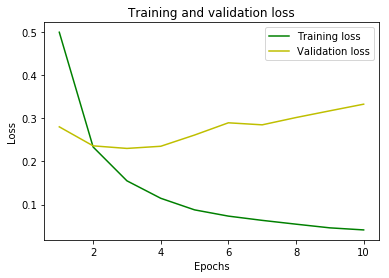

In [0]:
plt.clf()
loss = history7.history['loss']
val_loss = history7.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
import pandas as pd
import nltk
from nltk.corpus import stopwords #to remove stopword
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.stem import LancasterStemmer
nltk.download('stopwords')
nltk.download('wordnet')
# import jsonpickle
import numpy as np
import re #for clean data
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import tweepy
import csv
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

np.random.seed(2018)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
text = data[:100000]
text_new = [] #Initialize empty array to append clean text

for i in range(len(text)):
    text = re.sub('[^a-zA-Z]', ' ', data['text'][i])
    text = text.lower() #convert to lover case
    text = text.split() #split to array (default delimiter is " ")
    ps = PorterStemmer() #creating porterStemmer object to take main stem of each word
    text = [ps.stem(word) for word in text if not word in set(stopwords.words('indonesian'))] #loop for stemming each word in string array at i-th row
    text_new.extend(text)

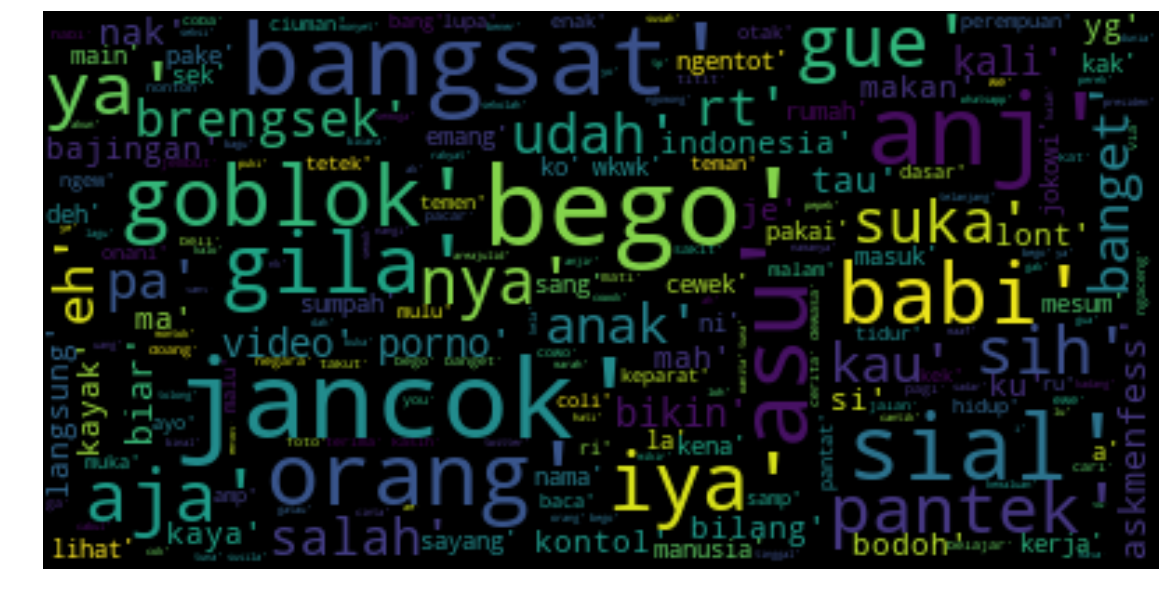

In [0]:
wordcloud = WordCloud(background_color = "black", 
                      max_words = 200, 
                      max_font_size = 40, 
                      random_state = 10).generate(str(text_new))

plt.figure(figsize=(20, 15))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

In [0]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

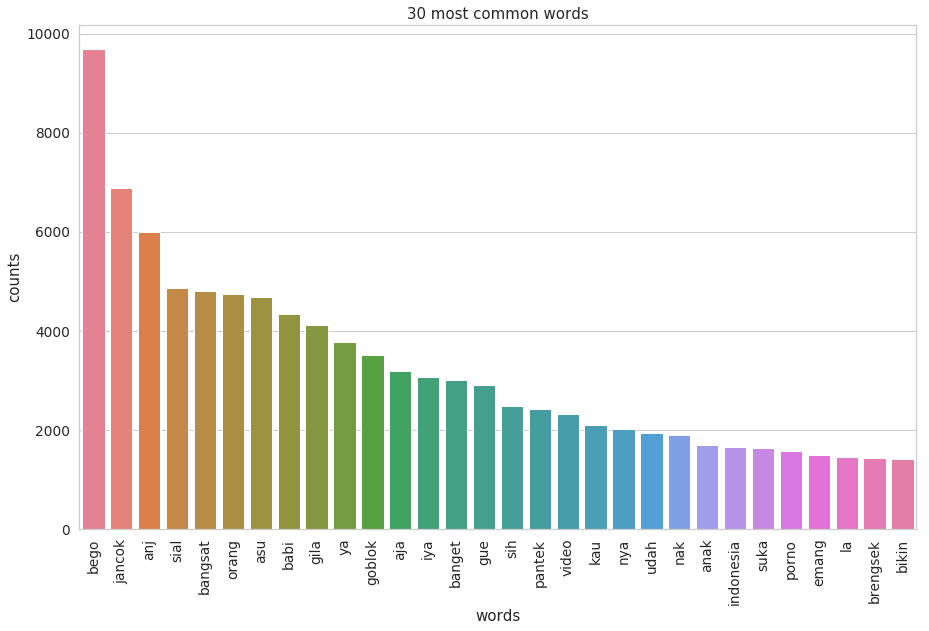

In [0]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:30]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='30 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(text_new)
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)